# Méthodes de descentes de gradients

Ce notebook vise à donner une première implémentations de descentes de gradients. Il s'agit d'en étudier les différents comportements en fonction des choix  
- des pas de descente 
- de points initiaux
- de norme pour la direction
- des nombres de conditionnements des hessiennes des fonctions objectifs.

In [1]:
import warnings
import numpy as np

### Calculer le gradient d'une fonction

Vous êtes invités à regarder la documentation `scipy` pour `derivative` et celle de `numpy` pour `gradient`. Elles donnent des approximations numériques respectivement de la dérivée d'une fonction à valeur numérique et du gradient d'une fonction éventuellement à plusieurs variables. Il peut être aussi intéréssant de regarder le calcul symbolique des dérivées avec `SymPy`.

Dans ce notebook, on choisit de faire les choses à la main en calculant les différences finies symétriques.

In [2]:
def partial(f, x, i=0, dx=1e-6):
    """Computes i-th partial derivative of f at point x.
    
    Args:
        f: objective function.
        x: point at which partial derivative is computed.
        i: coordinate along which derivative is computed.
        dx: slack for finite difference.
        
    Output:
        (float)

    """
    x = x.reshape(1, -1)
    h = np.zeros(x.shape)
    h[0, i] = dx
    return (f(x + h) - f(x - h)) / (2*dx)

In [3]:
partial(lambda x: x[0, 0]**4 + x[0, 1], np.array([5, 6]))

500.00000004502

In [4]:
def gradient(f, x, dx=1e-6):
    """Computes gradient of f at point x.
    
    Args:
        f: objective function.
        x: point at which gradient is computed.
        dx: slack for finite difference of partial derivatives.
        
    Output:
        (ndarray) of size domain of f.
        
    """
    x = x.reshape(1, -1)
    dim = x.shape[1]
    return np.array([partial(f, x, i, dx) for i in range(dim)]).reshape(1, -1)

In [5]:
gradient(lambda x: x[0, 0]**5 + x[0, 1]*2, np.array([1, 10]))

array([[5., 2.]])

## L'objet GD

On commence par définir un objet qui encode la descente de gradient. Notre choix et d'y implémenter un accès aux différents paramètres qui permettre de décliner la descente de gradient suivant l'usage qu'on souhaite en faire.

In [6]:
class GD():
    """Gradient Descent Object.
    
    Implements gradient descent aiming to compute optimal objective 
    value of convex functions and local optimal ones of none 
    convex functions.
    
    """    
    def __init__(self, d_dir=gradient, 
                 rate=(lambda x, y, z, grad: 0.01), 
                 decay=(lambda x: np.linalg.norm(x)), 
                 tol=1e-6, max_iter=1000, grad=gradient):
        """        
        Instantiates a GD object.
    
        Attributes:
        d_dir: function computing descent direction.
        rate: function computing learning rate ; takes in
              - f (function): objective function
              - x (ndarray): current iterate
              - dir_x (ndarray): output of a descent direction function
              - grad (ndarray): gradient function.
        decay: function computing decay.
        tol: slack tolerance.
        max_iter: upper bound on number of iterations.
    
        """
        self.d_dir = d_dir
        self.rate = rate
        self.decay = decay
        self.tol = tol
        self.max_iter = max_iter
        self.grad = gradient
    
    def __call__(self, x, f):
        """Calling gradient descent object with specific starting point and optimal function.
        
        Args:
            x: initial starting point for descent.
            f: objective function of optimisation problem.
        
        Output:
            (float) sub-optimal value up to tolerance if execution is proper.
            (ndarray) list of gradient descent iterates.
            
        """
        x = x.reshape(1, -1)
        n_iter = 0
        dir_x = -self.d_dir(f, x, self.tol)
        delta_x = self.rate(f, x, dir_x, n_iter) * dir_x
        iters, iters_dir = x, delta_x
        grad_f_x = self.grad(f, x)
        decay = self.decay(grad_f_x)
        while decay > self.tol and n_iter < self.max_iter:
            ## Deciding on direction
            dir_x = -self.d_dir(f, x, self.tol)
            delta_x = self.rate(f, x, dir_x, n_iter) * dir_x
            ## Updating iterate
            x = x + delta_x
            ## Storing on-going data
            iters_dir = np.vstack([iters_dir, delta_x])
            iters = np.vstack([iters, x])
            ## Computing decay
            grad_f_x = self.grad(f, x)
            decay = self.decay(grad_f_x)
            ## Updating iteration number
            n_iter += 1
        msg = " Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}."
        print(msg.format(n_iter, x.flatten(), f(x), decay))
        if decay > self.tol:
            warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)
        return (x, iters, iters_dir, n_iter) 

Pour être en mesure d'utiliser cet algorithme qui couvre l'essentiel des cas auxquels on peut faire face, il est nécessaire de définir les différents paramètres en entrées selon les descentes qu'on souhaite implémenter.
 

## Le pas de descente

On a abordé trois manières de calculer le pas de descente:

  - Un pas constant.
  - Calcul du pas optimal.
  - Le backtracking.
  
Seul la dernière stratégie nécessite l'affinage éventuel d'hyperparamètres, les fameux hyperparamètres $\alpha$ et $\beta$. Par défaut on les fixent respectivement à $0.01$ et $0.8$. Pour l'instant on se limite au cas du pas constant. Il sera suggéré dans la suite d'implémenter le cas d'un pas décroissant puis du backtracking.

In [7]:
class backtracking():
    def __init__(self, alpha=0.01, beta=0.8, max_iter=100):
        self.alpha = alpha
        self.beta = beta
        self.max_iter = max_iter
    def __call__(self, f, x, dir_x, n_iter=None):
        n_while = 0
        t = 1
        x = x.reshape(1, -1)
        grad_f = gradient(f, x)
        while f(x + t*dir_x) > f(x) + self.alpha*t*grad_f.dot(dir_x.T) and n_while < self.max_iter:
            t = self.beta*t
            n_while += 1
        return t

In [8]:
f = lambda x: 3*x[0]**2 + 2*x[0] + 1
x = np.array([10])
back = backtracking()
back(f, x, -gradient(f, x))

0.32768000000000014

## Directions de descentes

On a vu jusqu'à présent trois types de descentes : 

 - La déscente standard : la direction de descente est celle du gradient.
 - La déscente de plus forte pente dans le cas de la norme l1 : la direction de descente suit le vecteur de la base canonique de plus grande dérivée partielle.
 - L'algorithme de Newton où il s'agit de calculer l'inverse des hessiennes au point courant. 
 
*L'algorithme de Newton sera abordé dans l'extension de ce TP.*
 
Avant de s'intéresser à chacune de ces approches il nous faut être en mesure de calculer la valeur du gradient en un point courant. Tous les algos de descente font usage de ce calcul. On commence donc par un apparté sur ce point qui reste relativement technique. 

**Dans la pratique quand on fait face à un problème spécifique, et pour lequel on peut calculer le gradient de la fonction objective explicitement, on effectue ce calcule préalablement. Il est donc codé en dur.**


### Calculer les directions de descentes

- Cas de la descente de gradient standard : cette direction est celle par défaut dans la classe qu'on a implémenté. 

- Cas de la descente de gradient à pas optimal en norme l1

In [9]:
def d_sgd(f, x, dx=1e-6):
    x = x.reshape(1, -1)
    dim = x.shape[1]
    sdescent = np.array([0]*dim, dtype=float).reshape(1, -1)
    ## Computing the highest absolute value among coeffs 
    ## of coordinates in gradient.
    abs_grad = np.abs(gradient(f, x, dx))
    imax_diff = np.argmax(abs_grad) 
    sdescent[0, imax_diff] = abs_grad[0, imax_diff]
    return sdescent      

- Cas de l'algorithme de Newton

## Visualiser la convergence

Dans le cas des problèmes d'optimisation où la fonction objective est une fonction à une ou deux variables réelles, il est possible de visualiser les itérations de l'algorithme de descente. Dans le cas de la dimension $1$ on est en mesure de tracer le graphe de la fonction objective, dans le second quelques courbes de niveaux. 

In [10]:
rate_b = backtracking(alpha=0.001, beta=0.5)
DG_classic = GD()

In [11]:
op_pt, iters, iters_dir, n_iter = DG_classic(np.array([10]), lambda x: 3*x[0]**2 + 2*x[0] + 1)

 Iteration nu. = 290
 approx. = [-0.33333317]
 ob value = [0.66666667]
 and decay = 9.987566329527908e-07.


In [12]:
from matplotlib import pyplot as plt
import seaborn as sns

In [13]:
sns.set_style("whitegrid")

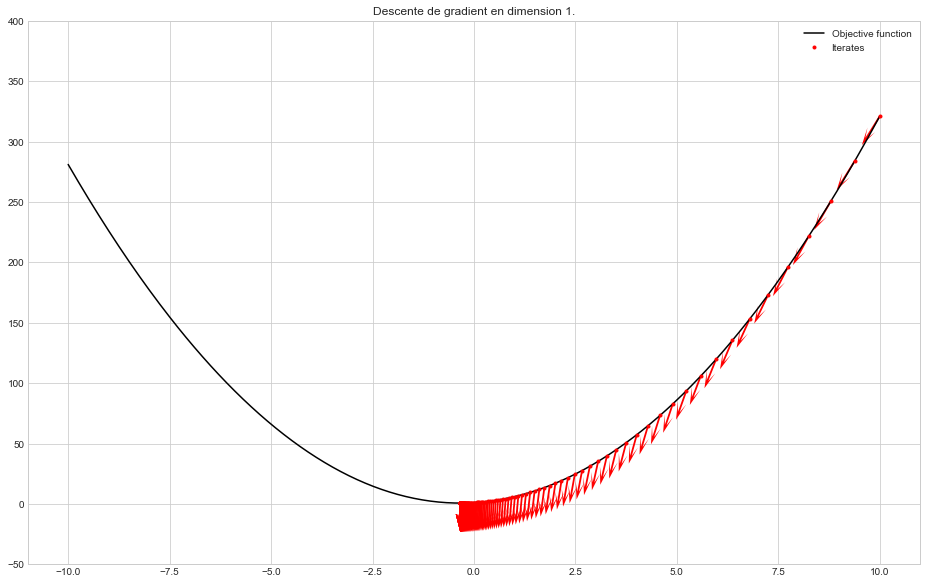

In [14]:
fig, ax = plt.subplots(figsize=(16, 10))
f = lambda x : 3*x**2 + 2*x + 1
x = np.linspace(-10, 10, 400)
ax.set_ylim(-50, 400)
ax.plot(x, f(x), "k-", label="Objective function")
# reshaping iters for input
iters_reshape = iters.reshape(iters.shape[0], 1)
ax.plot(iters_reshape, f(iters_reshape), 'r.', label="Iterates")
ax.quiver(iters_reshape, f(iters_reshape), iters_dir, -1, 
          color='r', scale=None, width=0.002, headwidth=5, headlength=10)
ax.set_title("Descente de gradient en dimension 1.")
ax.legend()

In [15]:
g = lambda x: x[0, 0]**2 + 10*x[0, 1]**2
op_pt_2, iters_2, iters_dir_2, n_iter_2 = DG_classic(np.array([1.5, 1.5]), g)

 Iteration nu. = 739
 approx. = [ 4.92222198e-07 -9.18170480e-23]
 ob value = 2.422826926562737e-13
 and decay = 9.844443969189396e-07.


#### A quick dive into `meshgrid`

In [16]:
x = np.linspace(0, 2, 3)
y = np.linspace(0, 2, 3)
X, Y = np.meshgrid(x, y)
np.vstack([X.reshape(1, -1), Y.reshape(1, -1)]).reshape(1, 2, -1)

array([[[0., 1., 2., 0., 1., 2., 0., 1., 2.],
        [0., 0., 0., 1., 1., 1., 2., 2., 2.]]])

#### Back to work

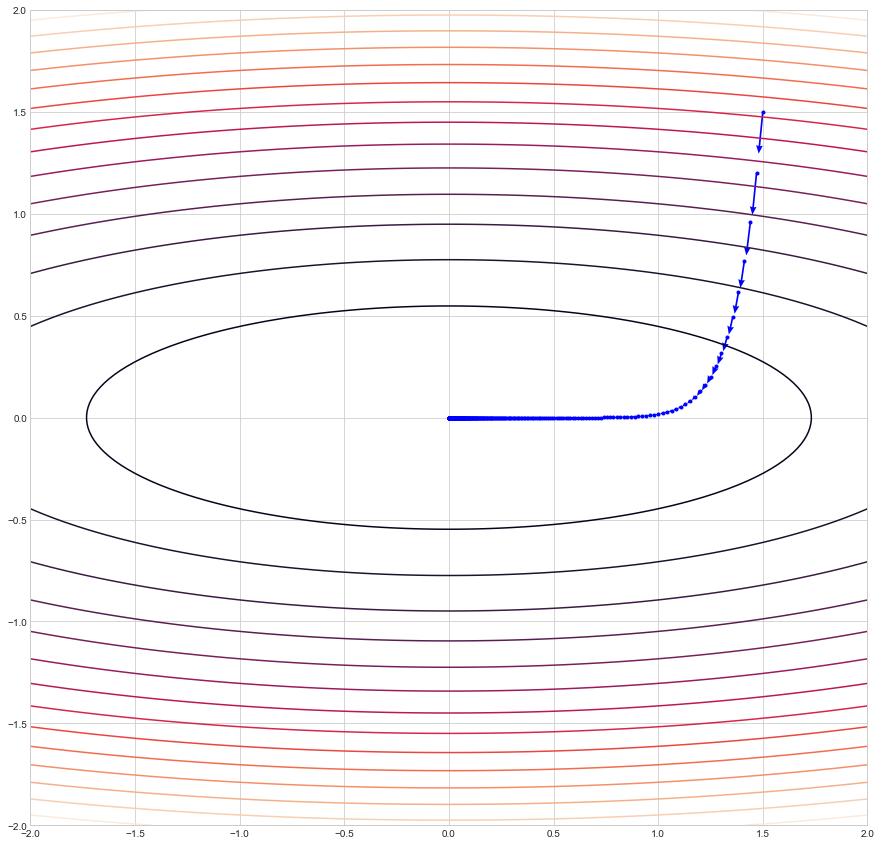

In [17]:
nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -2, 2, -2, 2
fig, ax = plt.subplots(figsize=(15, 15))
x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(x_mi, x_ma, nb_pts)
X, Y = np.meshgrid(x, y)
## Reshaping X, Y for proper evaluation by input function
x_y = np.vstack([X.reshape(1, -1), Y.reshape(1, -1)]).reshape(1, 2, -1)
ax.set_xlim(x_mi, x_ma)
ax.set_ylim(y_mi, y_ma)
ax.contour(X, Y, g(x_y).reshape(nb_pts, -1), 15)
ax.quiver(iters_2[:, 0], iters_2[:, 1], iters_dir_2[:, 0], iters_dir_2[:, 1],
          color='b', scale=6, width=0.002, headwidth=4, headlength=5)
ax.plot(iters_2[:, 0], iters_2[:, 1], 'b.')

You're invited to plot out the gradients along the descent if you wish to as well. The next chunk of code enables you to figure out how to reshape input for evaluation by objective function.

In [18]:
## Reshaping iters_2 for proper evaluation by input function
iters_2_g = np.vstack([iters_2[:, 0], iters_2[:,1]]).reshape(1, 2, -1)

### Analyse de convergence

In [19]:
conds = np.linspace(1, 500, 500)  # List of parameters for conditionning numbers

In [20]:
class fun_gamma():
    def __init__(self, gamma):
        self.gamma = gamma
    def __call__(self, x):
        return x[0, 0]**2 + self.gamma*x[0, 1]**2

In [21]:
t_family = []
for gamma in conds:
    f = fun_gamma(gamma)
    t_family.append(f)

In [22]:
rate_c = backtracking(0.001, 0.2)
GD_d = GD(max_iter=10000)